# Lymphoma vs GBM paper : Part B

@LaurentMombaerts 14/04/2021

Raman spectrum have been preprocessed with outliers removal and SG detrending algorithm

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
%whos

Interactive namespace is empty.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io # For Matlab files (.mat)

# Figures size in the notebook 
plt.rcParams['figure.figsize'] = [15, 10]

# Load filtered mat files 
data = scipy.io.loadmat('./data/FFPE_data_14042021.mat')

# Transform into dataframe
gbm_data = pd.DataFrame(data['gbm_ffpe'][:,20:1570])
lympho_data = pd.DataFrame(data['lympho_ffpe'][:,20:1570])

# Patient IDs
gbm_ID = np.array([61897,61897,61897,61897,61897,61897,61897,
                18681,18681,18681,18681,
                25702,25702,25702,25702,25702,25702,25702,
                29275,29275,29275,29275,
                54104,54104,54104,54104,
                16688,16688,16688,16688])
gbm_patientID = pd.DataFrame(gbm_ID.T,columns=['PatientID'])
lympho_ID = np.array([18087,18087,18087,18087,
                            32293,32293,32293,32293,32293,32293,32293,
                            52108,52108,52108,52108])
lympho_patientID = pd.DataFrame(lympho_ID.T,columns=['PatientID'])

In [4]:
# Quick stats 
print('Infos patients and spectrums : ')
print('')
print('gbm spectrum = ' + str(gbm_data.shape[0]))
print('lympho spectrum = ' + str(lympho_data.shape[0]))
print('')
print(gbm_patientID.value_counts())
print('')
print(lympho_patientID.value_counts())

Infos patients and spectrums : 

gbm spectrum = 30
lympho spectrum = 15

PatientID
61897        7
25702        7
54104        4
29275        4
18681        4
16688        4
dtype: int64

PatientID
32293        7
52108        4
18087        4
dtype: int64


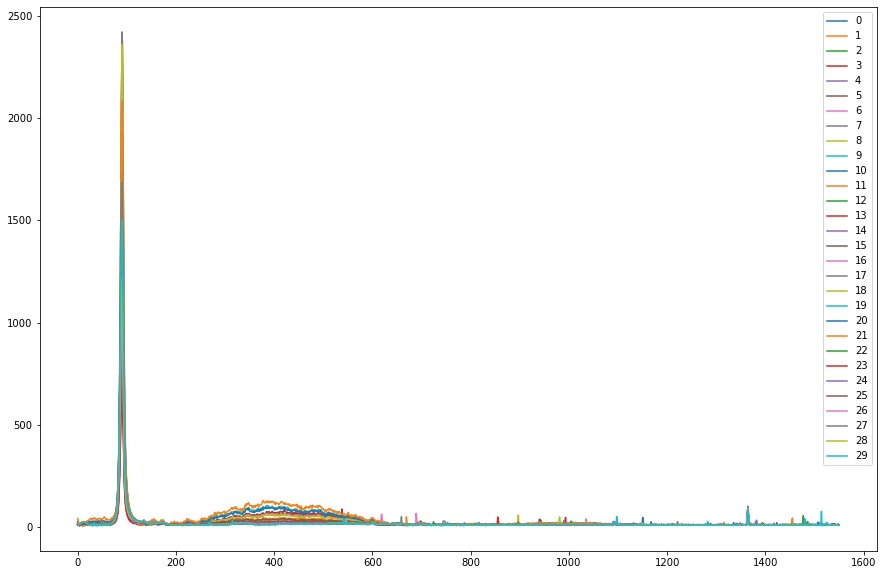

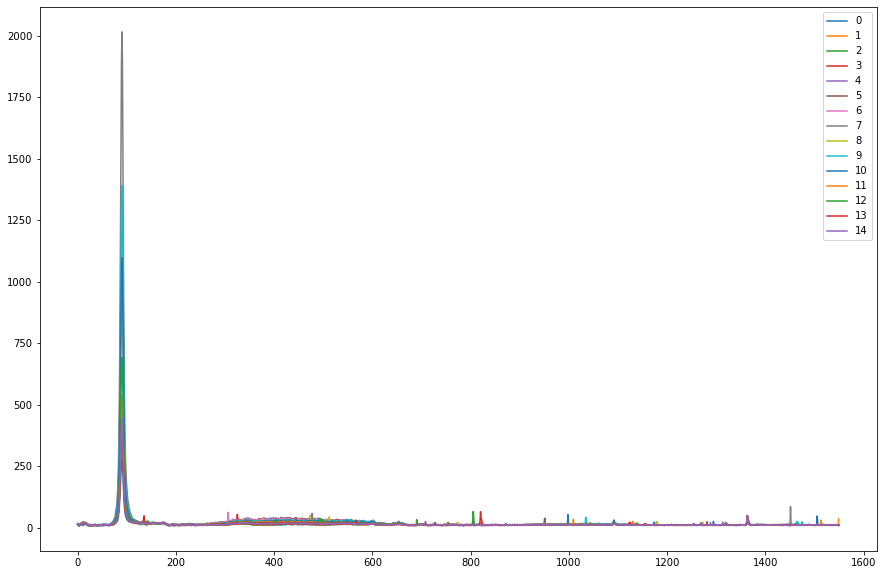

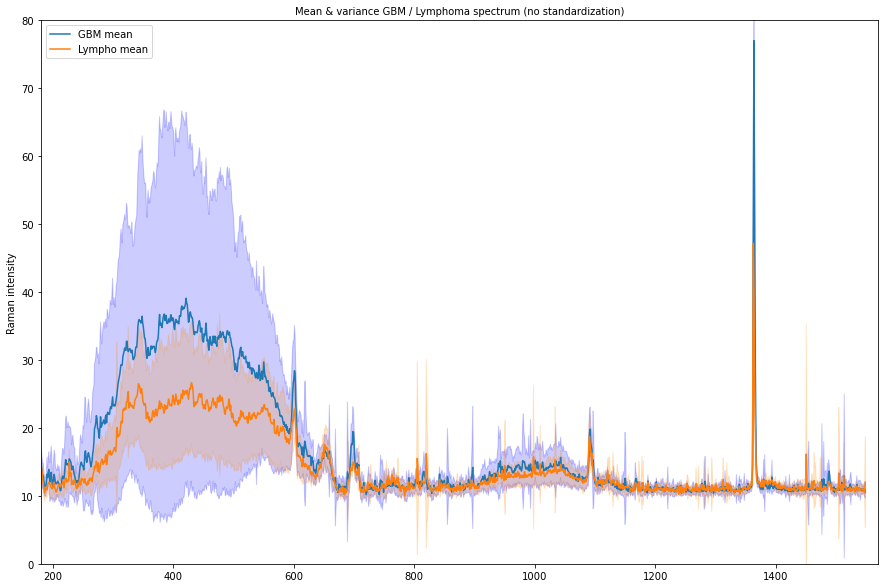

In [6]:
gbm_data.T.plot()
lympho_data.T.plot()

# Show mean std overlap
mean_GBM = gbm_data.mean(axis=0)
std_GBM = gbm_data.std(axis=0)
mean_lympho = lympho_data.mean(axis=0)
std_lympho = lympho_data.std(axis=0)

x_axis_ticks = list(range(0,gbm_data.shape[1]))

plt.figure()
plt.title('Mean & variance GBM / Lymphoma spectrum (no standardization)')
plt.ylabel('Raman intensity')
plt.plot(x_axis_ticks, mean_GBM)
plt.plot(x_axis_ticks, mean_lympho)
plt.fill_between(x_axis_ticks, mean_GBM - std_GBM, mean_GBM + std_GBM, color='blue', alpha=.2)
plt.fill_between(x_axis_ticks, mean_lympho - std_lympho, mean_lympho + std_lympho, color='darkorange', alpha=.2)
plt.legend(['GBM mean','Lympho mean'],loc='upper left')
plt.xlim((180,1570))
plt.ylim((0,80))
#plt.savefig('GBM_Lymphoma_mean_std.pdf')
plt.show()

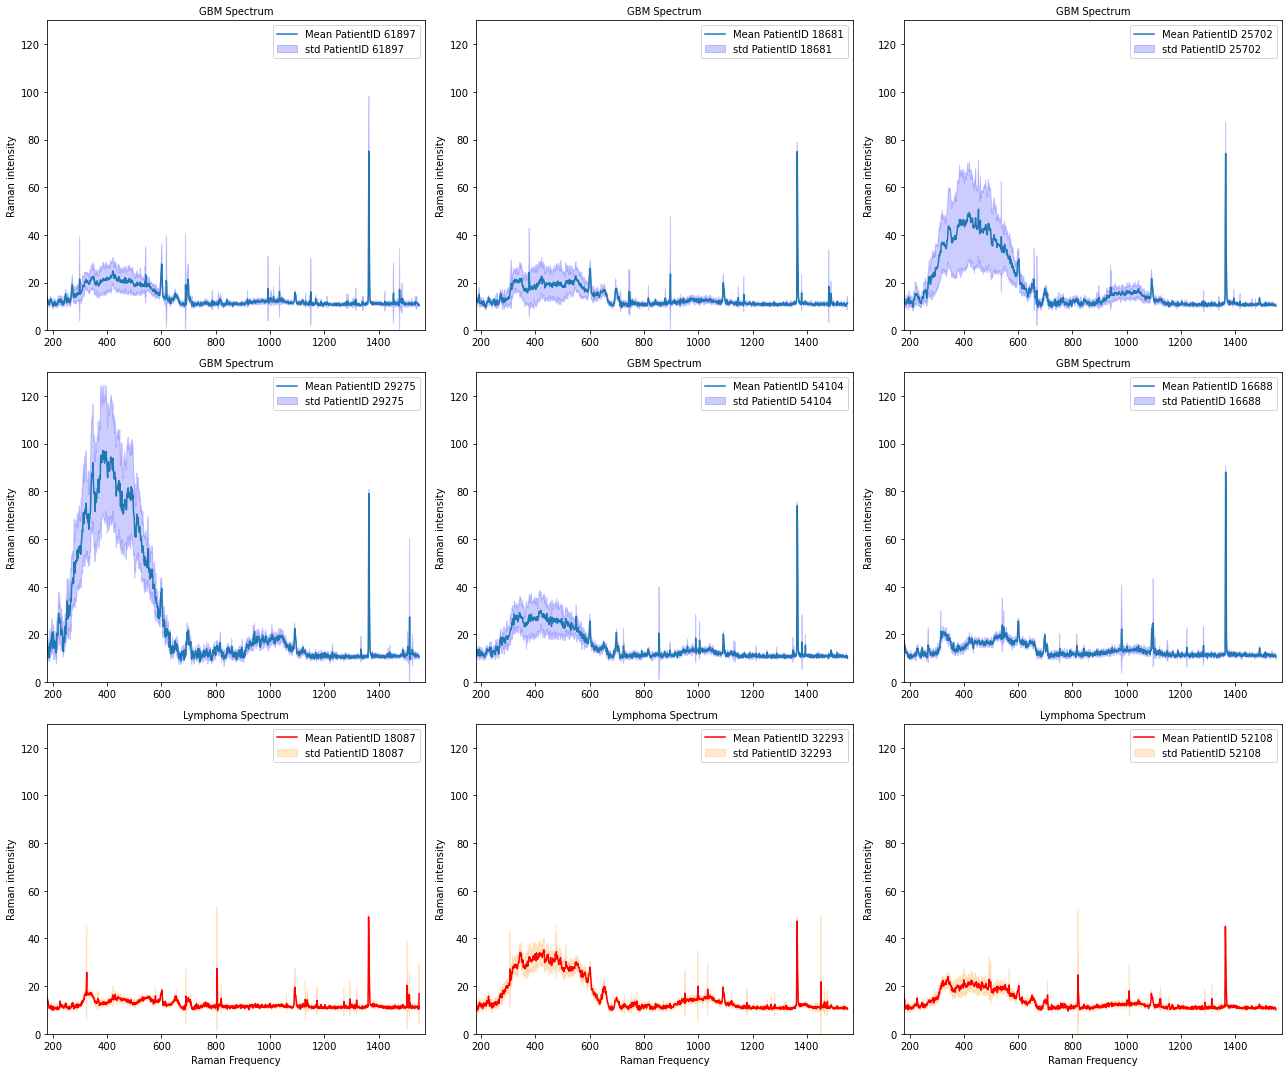

In [7]:
uniqueGBMPatient = gbm_patientID['PatientID'].unique()
uniqueLymphoPatient = lympho_patientID['PatientID'].unique()

plt.figure(figsize=[18,15])
plt.rc('font', size=10)
plt.rc('axes', titlesize=10)     
plt.rc('axes', labelsize=10)

temp = 1
for patientID in uniqueGBMPatient:
    spectrumToConsider = gbm_data[gbm_patientID['PatientID'] == patientID].reset_index(drop=True)
    mean_spec = spectrumToConsider.mean(axis=0)
    std_spec = spectrumToConsider.std(axis=0)  
    plt.subplot(3,3,temp)
    plt.title('GBM Spectrum')
    plt.ylabel('Raman intensity')
    plt.plot(x_axis_ticks, mean_spec, label='Mean PatientID ' + str(patientID))
    plt.fill_between(x_axis_ticks, mean_spec - std_spec, mean_spec + std_spec, color='blue', alpha=.2, label='std PatientID ' + str(patientID))
    plt.legend(loc='upper right')
    plt.xlim((180,1570))
    plt.ylim((0,130))
    temp = temp + 1
    #plt.savefig('GBM_Patient_' + str(patientID) + '.pdf')
    
for patientID in uniqueLymphoPatient:
    spectrumToConsider = lympho_data[lympho_patientID['PatientID'] == patientID].reset_index(drop=True)
    mean_spec = spectrumToConsider.mean(axis=0)
    std_spec = spectrumToConsider.std(axis=0)
    plt.subplot(3,3,temp)
    plt.title('Lymphoma Spectrum')
    plt.xlabel('Raman Frequency')
    plt.ylabel('Raman intensity')
    plt.plot(x_axis_ticks, mean_spec, color='red',label='Mean PatientID ' + str(patientID))
    plt.fill_between(x_axis_ticks, mean_spec - std_spec, mean_spec + std_spec, color='darkorange', alpha=.2, label='std PatientID ' + str(patientID))
    plt.legend(loc='upper right')
    #plt.savefig('Lymphoma_Patient_' + str(patientID) + '.pdf')
    plt.xlim((180,1570))
    plt.ylim((0,130))
    temp = temp + 1
plt.tight_layout()
plt.savefig('SuppFigure_FFPE.pdf', dpi=800)
plt.show()

**Functions**

In [9]:
# To run before any classification

from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score, f1_score, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, RepeatedKFold, cross_val_score, RepeatedStratifiedKFold, GroupShuffleSplit, RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
#import shap

def findOptimalPointROC(mean_tpr,mean_fpr):
    dist = np.ones(len(mean_tpr),)
    for i in range(len(mean_tpr)):
        dist[i] = np.sqrt((0-mean_fpr[i])**2 + (1-mean_tpr[i])**2)
    opt_idx = np.where(dist == min(dist))
    return mean_tpr[opt_idx], mean_fpr[opt_idx]

def findOptimalPointPRC(mean_precision,mean_recall):
    dist = np.ones(len(mean_precision),)
    for i in range(len(mean_precision)):
        dist[i] = np.sqrt((1-mean_recall[i])**2 + (1-mean_precision[i])**2)
    opt_idx = np.where(dist == min(dist))
    return mean_precision[opt_idx], mean_recall[opt_idx]

def plotROC(tprs,mean_fpr,aucs):
    
    fig, ax = plt.subplots()       
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='navy',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='darkorange',
            label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Internal Validation ROC Curve")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid()
    tpr_opt, fpr_opt = findOptimalPointROC(mean_tpr,mean_fpr) # Find optimal point ROC (closest from top left)
    #ax.plot(fpr_opt, tpr_opt,'bo-', label=r'Optimal Decision : (%0.2f , %0.2f)' % (fpr_opt,tpr_opt))
    ax.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    return

def plot_allROC(tprs,mean_fpr,aucs):
    
    fig, ax = plt.subplots()       
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='navy',
            label='Chance', alpha=.8)
    
    for i in range(np.shape(tprs)[0]):
        ax.plot(mean_fpr, tprs[i],
                label=r'Mean ROC (AUC = %0.4f)' % (aucs[i]),
                lw=2, alpha=.8)

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Internal Validation ROC Curve")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid()
    plt.tight_layout()
    ax.legend(loc="lower right")
    plt.show()

    return

def plotPR(precisions,mean_recall,auprs,no_sk):
    
    fig, ax = plt.subplots()
    plt.plot([0, 1], [no_sk, no_sk], linestyle='--',color='navy', label='Chance')
    
    mean_precision = np.mean(precisions, axis=0)
    mean_aupr = auc(mean_recall, mean_precision)
    std_aupr = np.std(auprs)
    ax.plot(mean_recall, mean_precision, color='darkorange',
            label=r'Mean PR (AUC = %0.2f $\pm$ %0.2f)' % (mean_aupr, std_aupr),
            lw=2, alpha=.8)

    std_precision = np.std(precisions, axis=0)
    precisions_upper = np.minimum(mean_precision + std_precision, 1)
    precisions_lower = np.maximum(mean_precision - std_precision, 0)
    ax.fill_between(mean_recall, precisions_lower, precisions_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="PR Curve Internal Validation")

    plt.xlabel("Recall")
    plt.ylabel("Precision")  
    

    mean_precision_opt, mean_recall_opt = findOptimalPointPRC(mean_precision,mean_recall)
    #ax.plot(mean_recall_opt, mean_precision_opt,'bo-', label=r'Optimal Decision : (%0.2f , %0.2f)' % (mean_recall_opt,mean_precision_opt))
    ax.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.show()

    return

def plot_allPR(precisions,mean_recall,auprs):
    
    fig, ax = plt.subplots()
    for i in range(np.shape(precisions)[0]):
        ax.plot(mean_recall, precisions[i],
                label=r'Mean PR (AUC = %0.2f)' % (auprs[i]),
                lw=2, alpha=.8)

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="PR Curve Internal Validation")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid()
    plt.tight_layout()
    ax.legend(loc="lower right")
    plt.show()

    return

def plotF1_scores(thresholds, F1_scores_atThr):

    max_mean_f1_idx = np.argmax(np.mean(F1_scores_atThr,axis=0))
    f1_at_max = np.array(F1_scores_atThr)[:,max_mean_f1_idx]
    print('Best threshold (max F1 score) : ' + str(thresholds[max_mean_f1_idx]))
    print('Best mean F1 score : ' + str(np.mean(f1_at_max)))
    print('Corresponding std at argmax best F1 score : ' + str(np.std(f1_at_max)))

    f1_upper = np.minimum(np.mean(F1_scores_atThr,axis=0) + np.std(F1_scores_atThr,axis=0), 1)
    f1_lower = np.maximum(np.mean(F1_scores_atThr,axis=0) - np.std(F1_scores_atThr,axis=0), 0)

    plt.figure()
    plt.plot(thresholds,np.mean(F1_scores_atThr,axis=0))
    plt.fill_between(thresholds, f1_upper, f1_lower, color='grey', alpha=.2)
    plt.plot(thresholds[max_mean_f1_idx], np.mean(f1_at_max),'bo-', label=r'Optimal Decision : (%0.2f , %0.2f)' % (thresholds[max_mean_f1_idx],np.mean(f1_at_max)))
    plt.title('F1 score by threshold')
    plt.xlabel('Thresholds')
    plt.ylabel('F1 score')
    plt.legend()
    plt.show()
    
    return

def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return TP, FP, TN, FN

def g_means_computation(y_actual, y_hat):
    
    TP, FP, TN, FN = perf_measure(y_actual,y_hat)
    fpr = FP / (FP + TN)
    tpr = TP / (TP + FN)
    
    return np.sqrt(tpr * (1-fpr))
    
def return_tpr(y_actual, y_hat):
    
    TP, FP, TN, FN = perf_measure(y_actual,y_hat)
    fpr = FP / (FP + TN)
    tpr = TP / (TP + FN)
    
    return tpr

def return_fpr(y_actual, y_hat):
    
    TP, FP, TN, FN = perf_measure(y_actual,y_hat)
    fpr = FP / (FP + TN)
    tpr = TP / (TP + FN)
    
    return fpr

def plotgmeans_scores(thresholds, gmeans):

    max_mean_gmeans_idx = np.argmax(np.mean(gmeans,axis=0))
    gmeans_at_max = np.array(gmeans)[:,max_mean_gmeans_idx]
    print('Best threshold (max gmean score) : ' + str(thresholds[max_mean_gmeans_idx]))
    print('Best mean gmean score : ' + str(np.mean(gmeans_at_max)))
    print('Corresponding std at argmax best gmean score : ' + str(np.std(gmeans_at_max)))

    gmeans_upper = np.minimum(np.mean(gmeans,axis=0) + np.std(gmeans,axis=0), 1)
    gmeans_lower = np.maximum(np.mean(gmeans,axis=0) - np.std(gmeans,axis=0), 0)

    #plt.figure()
    #plt.plot(thresholds,np.mean(gmeans,axis=0))
    #plt.fill_between(thresholds, gmeans_upper, gmeans_lower, color='grey', alpha=.2)
    #plt.plot(thresholds[max_mean_gmeans_idx], np.mean(gmeans_at_max),'bo-', label=r'Optimal Decision : (%0.2f , %0.2f)' % (thresholds[max_mean_gmeans_idx],np.mean(gmeans_at_max)))
    #plt.title('Gmeans score by threshold')
    #plt.xlabel('Thresholds')
    #plt.ylabel('Gmean score')
    #plt.legend()
    #plt.show()
    
    return thresholds[max_mean_gmeans_idx], max_mean_gmeans_idx

def computeOverall_Metrics_atBestThr(perf_storage,bestThr_idx):
    #TP, FP, TN, FN
    all_sensitivity = []
    all_specificity = []
    all_precision = []
    all_accuracy = []
    all_b_accuracy = []
    
    metrics = dict()
    
    for i in range(np.shape(perf_storage)[0]):
        TP = perf_storage[i][bestThr_idx][0]
        FP = perf_storage[i][bestThr_idx][1]
        TN = perf_storage[i][bestThr_idx][2]
        FN = perf_storage[i][bestThr_idx][3]
        sensitivity = TP/(TP+FN)
        specificity = TN/(TN+FP)
        precision = TP/(TP+FP)
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        b_accuracy = (sensitivity + specificity) / 2
        all_sensitivity.append(sensitivity)
        all_specificity.append(specificity)
        all_precision.append(precision)
        all_accuracy.append(accuracy)
        all_b_accuracy.append(b_accuracy)
        
    print('')
    print('Sensitivity = ' + str(np.mean(all_sensitivity)) + ' +- ' + str(np.std(all_sensitivity)))
    print('Specificity = ' + str(np.mean(all_specificity)) + ' +- ' + str(np.std(all_specificity)))
    print('Precision = ' + str(np.mean(all_precision)) + ' +- ' + str(np.std(all_precision)))
    print('Accuracy = ' + str(np.mean(all_accuracy)) + ' +- ' + str(np.std(all_accuracy)))
    print('Balanced accuracy = ' + str(np.mean(all_b_accuracy)) + ' +- ' + str(np.std(all_b_accuracy)))
    
    metrics['Sensitivity'] = all_sensitivity
    metrics['Specificity'] = all_specificity
    metrics['Precision'] = all_precision
    metrics['Accuracy'] = all_accuracy
    metrics['Balanced_accuracy'] = all_b_accuracy

    return metrics

def trainModel(X,y,model,folds):
    
    # Init perf
    tprs = []
    precisions = []
    aucs = []
    auprs = []
    mean_fpr = np.linspace(0, 1, 100)    
    mean_recall = np.linspace(0, 1, 100)
    F1_scores_atThr = []
    all_gmeans = []
    perf_storage = []
    all_tprs = []
    all_fprs = []
    
    no_sk = []
    # Training loop
    for j, (train, test) in enumerate(folds.split(X, y)):

        # CV definition
        X_train, X_test = X.iloc[train,:], X.iloc[test,:]
        y_train, y_test = y[train],y[test]

        # Model definition
        model.fit(X_train,y_train)
        y_scores = model.predict_proba(X_test)

        # FPR, TPR, ROC Scores append internal
        fpr, tpr, thresh_roc = roc_curve(y_test, y_scores[:,1])
        roc_auc = auc(fpr,tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        tprs.append(interp_tpr)
        aucs.append(roc_auc)       

        # calculate the g-mean for each threshold 
        thresholds = np.arange(0, 1, 0.001)
        scores_tpr = [return_tpr(y_test,(y_scores[:,1] >= t).astype('int')) for t in thresholds]
        all_tprs.append(scores_tpr)
        scores_fpr = [return_fpr(y_test,(y_scores[:,1] >= t).astype('int')) for t in thresholds]
        all_fprs.append(scores_fpr)
        
        scores_g = [g_means_computation(y_test,(y_scores[:,1] >= t).astype('int')) for t in thresholds]
        all_gmeans.append(scores_g)

        # Precision, Recall, PR Scores append internal
        precision, recall, thresh_pr = precision_recall_curve(y_test, y_scores[:,1])
        aupr = auc(recall, precision)      
        reversed_recall = np.fliplr([recall])[0]
        reversed_precision = np.fliplr([precision])[0]
        interp_precision = np.interp(mean_recall, reversed_recall, reversed_precision)
        precisions.append(interp_precision)
        auprs.append(aupr)

        no_sk.append(len(y_test[y_test==1]) / len(y_test))

        # (Somehow redundant for now:) Compute F1 score at each threshold - should be improved by interpolation with roc_curve
        # define thresholds & evaluate at each threshold
        thresholds = np.arange(0, 1, 0.001)
        scores = [f1_score(y_test,(y_scores[:,1] >= t).astype('int')) for t in thresholds]
        F1_scores_atThr.append(scores)

        # Compute performances metrics at all thresholds
        perf_metrics = [perf_measure(y_test,(y_scores[:,1] >= t).astype('int')) for t in thresholds]
        perf_storage.append(perf_metrics)

    #plotROC(tprs,mean_fpr,aucs)
    #plotPR(precisions,mean_recall,auprs,np.mean(no_sk))
    plotROC_PR(tprs,mean_fpr,aucs,precisions,mean_recall,auprs,np.mean(no_sk),0)
    
    # plotF1_scores(thresholds, F1_scores_atThr)
    bestThr, bestThr_idx = plotgmeans_scores(thresholds, all_gmeans)
    metrics = computeOverall_Metrics_atBestThr(perf_storage,bestThr_idx)
    #plot_allROC(tprs,mean_fpr,aucs)
    #plot_allPR(precisions,mean_recall,auprs)
    
    metrics['AUROC'] = aucs
    metrics['AUPR'] = auprs
    
    print('AUROC = ' + str(np.mean(aucs)) + ' +- ' + str(np.std(aucs)))
    print('AUPR = ' + str(np.mean(auprs)) + ' +- ' + str(np.std(auprs)))
    
    metrics['TPRS_by_threshold'] = all_tprs
    metrics['FPRS_by_threshold'] = all_fprs
    
    return metrics

def trainModel_patientSplit(X,y,groups,model,splits):
    
    # Init perf
    tprs = []
    precisions = []
    aucs = []
    auprs = []
    mean_fpr = np.linspace(0, 1, 100)    
    mean_recall = np.linspace(0, 1, 100)
    F1_scores_atThr = []
    all_gmeans = []
    perf_storage = []
    no_sk = []
    
    for random_split in range(splits):
        gss = GroupShuffleSplit(n_splits=1, train_size=.66, random_state=random_split)
        gss.get_n_splits()
        
        for train, test in gss.split(X, y, groups):
            # CV definition
            X_train, X_test = X.iloc[train,:], X.iloc[test,:]
            y_train, y_test = y[train],y[test]

            # Model definition
            model.fit(X_train,y_train)
            y_scores = model.predict_proba(X_test)

            # FPR, TPR, ROC Scores append internal
            fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1]) 
            roc_auc = auc(fpr,tpr)
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            tprs.append(interp_tpr)
            aucs.append(roc_auc)

            # Precision, Recall, PR Scores append internal
            precision, recall, thresholds = precision_recall_curve(y_test, y_scores[:,1])
            aupr = auc(recall, precision)      
            reversed_recall = np.fliplr([recall])[0]
            reversed_precision = np.fliplr([precision])[0]
            interp_precision = np.interp(mean_recall, reversed_recall, reversed_precision)
            precisions.append(interp_precision)
            auprs.append(aupr)
            
            # calculate the g-mean for each threshold 
            thresholds = np.arange(0, 1, 0.001)
            scores_g = [g_means_computation(y_test,(y_scores[:,1] >= t).astype('int')) for t in thresholds]
            all_gmeans.append(scores_g)

            no_sk.append(len(y_test[y_test==1]) / len(y_test))

            # (Somehow redundant for now:) Compute F1 score at each threshold - should be improved by interpolation with roc_curve
            # define thresholds & evaluate at each threshold
            thresholds = np.arange(0, 1, 0.001)
            scores = [f1_score(y_test,(y_scores[:,1] >= t).astype('int')) for t in thresholds]
            F1_scores_atThr.append(scores)
        
            # Compute performances metrics at all thresholds
            perf_metrics = [perf_measure(y_test,(y_scores[:,1] >= t).astype('int')) for t in thresholds]
            perf_storage.append(perf_metrics)
        
    #plotROC(tprs,mean_fpr,aucs)
    #plotPR(precisions,mean_recall,auprs,np.mean(no_sk))
    #plotF1_scores(thresholds, F1_scores_atThr)
    
    plotROC_PR(tprs,mean_fpr,aucs,precisions,mean_recall,auprs,np.mean(no_sk),1)
    
    bestThr, bestThr_idx = plotgmeans_scores(thresholds, all_gmeans)
    metrics = computeOverall_Metrics_atBestThr(perf_storage,bestThr_idx)
    metrics['AUROC'] = aucs
    metrics['AUPR'] = auprs
    
    print('AUROC = ' + str(np.mean(aucs)) + ' +- ' + str(np.std(aucs)))
    print('AUPR = ' + str(np.mean(auprs)) + ' +- ' + str(np.std(auprs)))
    
    return metrics

def plotROC_PR(tprs,mean_fpr,aucs,precisions,mean_recall,auprs,no_sk,validationType):
    
    if validationType == 0:
        titleROC = 'Internal Validation ROC Curve : Random Shuffling'
        titlePR = 'Internal Validation PR Curve : Random Shuffling'
        graphColor = 'darkorange'
    else:
        titleROC = 'Internal Validation ROC Curve : Patient Stratified'
        titlePR = 'Internal Validation PR Curve : Patient Stratified'
        graphColor = 'darkgreen'
        
    plt.figure(figsize=[15, 8])
    plt.subplot(1,2,1)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='navy',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color=graphColor,
            label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    plt.xlim((-0.05, 1.05))
    plt.ylim((-0.05, 1.05))
    
        
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid()
    tpr_opt, fpr_opt = findOptimalPointROC(mean_tpr,mean_fpr) # Find optimal point ROC (closest from top left)
    #ax.plot(fpr_opt, tpr_opt,'bo-', label=r'Optimal Decision : (%0.2f , %0.2f)' % (fpr_opt,tpr_opt))
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.title(titleROC)
    #plt.show()

    plt.subplot(1,2,2)
    plt.plot([0, 1], [no_sk, no_sk], linestyle='--',color='navy', label='Chance')
    
    mean_precision = np.mean(precisions, axis=0)
    mean_aupr = auc(mean_recall, mean_precision)
    std_aupr = np.std(auprs)
    plt.plot(mean_recall, mean_precision, color=graphColor,
            label=r'Mean PR (AUC = %0.2f $\pm$ %0.2f)' % (mean_aupr, std_aupr),
            lw=2, alpha=.8)

    std_precision = np.std(precisions, axis=0)
    precisions_upper = np.minimum(mean_precision + std_precision, 1)
    precisions_lower = np.maximum(mean_precision - std_precision, 0)
    plt.fill_between(mean_recall, precisions_lower, precisions_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    plt.xlim((-0.05, 1.05))
    plt.ylim((-0.05, 1.05))
    plt.title("Internal Validation PR Curve")

    plt.xlabel("Recall")
    plt.ylabel("Precision")  
    

    mean_precision_opt, mean_recall_opt = findOptimalPointPRC(mean_precision,mean_recall)
    #ax.plot(mean_recall_opt, mean_precision_opt,'bo-', label=r'Optimal Decision : (%0.2f , %0.2f)' % (mean_recall_opt,mean_precision_opt))
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.title(titlePR)
    plt.savefig('ROC_PR_x.pdf', dpi=800)
    plt.show()

    return

def evaluateCeffect_LR(X,y,rskf,c_values):
    
    all_aucs = []
    all_nonZero = []
    all_auprs = []
    
    # Evaluate effect of c hyperparameter on accuracy, then on features
    for c in c_values:   
        # Init
        aucs = []
        auprs = []
        count = []
        for j, (train, test) in enumerate(rskf.split(X, y)):

            # CV definition
            X_train, X_test = X.iloc[train,:], X.iloc[test,:]
            y_train, y_test = y[train],y[test]

            # Model definition
            log_reg_c = LogisticRegression(random_state=0, solver='liblinear', penalty='l1', C=c)
            log_reg_c.fit(X_train,y_train)
            y_scores = log_reg_c.predict_proba(X_test)

            # ROC Scores append
            fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
            roc_auc = auc(fpr,tpr)
            aucs.append(roc_auc)
            
            # PR Scores append
            precision, recall, thresholds = precision_recall_curve(y_test, y_scores[:,1])
            aupr = auc(recall, precision) 
            auprs.append(aupr)

            # Count of non zero features
            countNonZero = log_reg_c.coef_[0][log_reg_c.coef_[0] != 0].shape[0]
            count.append(countNonZero)

        all_aucs.append(aucs)
        all_auprs.append(auprs)
        all_nonZero.append(count)
        
    count = []
    aucs = []
    auprs = []
    for j, (train, test) in enumerate(rskf.split(X, y)):

        # CV definition
        X_train, X_test = X.iloc[train,:], X.iloc[test,:]
        y_train, y_test = y[train],y[test]

        # Model definition
        log_reg_c = LogisticRegression(random_state=0, solver='liblinear')
        log_reg_c.fit(X_train,y_train)
        y_scores = log_reg_c.predict_proba(X_test)

        # ROC Scores append
        fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
        roc_auc = auc(fpr,tpr)
        aucs.append(roc_auc)
        
        # PR Scores append
        precision, recall, thresholds = precision_recall_curve(y_test, y_scores[:,1])
        aupr = auc(recall, precision) 
        auprs.append(aupr)

        # Count of non zero features
        countNonZero = log_reg.coef_[0][log_reg.coef_[0] != 0].shape[0]
        count.append(0)

    all_aucs.append(aucs)
    all_auprs.append(auprs)
    all_nonZero.append(count)
    
    plt.figure(figsize=[10,10])
    plt.subplot(311)
    plt.title('AUROC, 2s ExpTime, by C L1 hyperparameter LogReg')
    plt.ylabel('AUROC')
    plt.boxplot(all_aucs)
    plt.grid()
    plt.xticks(range(1,5), [0.1, 0.5, 1, 'No Penalty'])
    
    plt.subplot(312)
    plt.title('AUPRS, 2s ExpTime, by C L1 hyperparameter LogReg')
    plt.ylabel('AUPR')
    plt.boxplot(all_auprs)
    plt.grid()
    plt.xticks(range(1,5), [0.1, 0.5, 1, 'No Penalty'])

    plt.subplot(313)
    plt.title('Count of corresponding non zero features')
    plt.ylabel('Number of non zero features')
    plt.boxplot(all_nonZero)
    plt.xticks(range(1,5), [0.1, 0.5, 1, 'No Penalty'])
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    return all_aucs, all_auprs, all_nonZero

**Random Forest directly**

In [131]:
# Random Forest hyperparameter optimization

# Data init
X = pd.concat([gbm_data, lympho_data]).reset_index(drop=True)
y = np.concatenate((np.zeros((gbm_data.shape[0],),dtype=int),np.ones((lympho_data.shape[0]),dtype=int)),axis=0)
groups = pd.concat([gbm_patientID, lympho_patientID]).reset_index(drop=True)

# Model definition
RF_default = RandomForestClassifier(class_weight='balanced', random_state=0) # With default parameters

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 150, num = 15)]

# Number of features to consider at every split
max_features = ['sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 50, num = 10)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2,5,10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,4]

# Method of selecting samples for training each tree
bootstrap = [True]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# cv
#cv = RepeatedStratifiedKFold(n_splits = 3, n_repeats = 3, random_state = 0)
#cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 0)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=0)

# Initialize grid search with 3 fold cross validation, 
rf_grid = GridSearchCV(estimator = RF_default, param_grid = param_grid, cv = cv, verbose=10, n_jobs = -1)

# Fit the random search model
rf_grid.fit(X,y)
print('Best parameters : ' + str(rf_grid.best_params_))

Fitting 15 folds for each of 1485 candidates, totalling 22275 fits
Best parameters : {'bootstrap': True, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


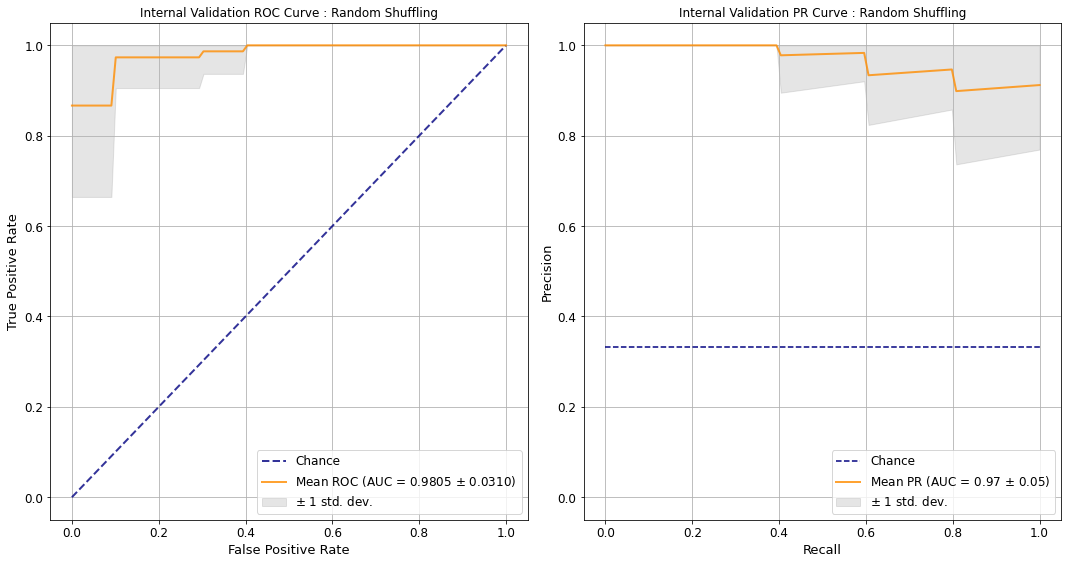

Best threshold (max gmean score) : 0.43
Best mean gmean score : 0.9385236856349315
Corresponding std at argmax best gmean score : 0.056331975841651

Sensitivity = 0.9333333333333335 +- 0.09428090415820632
Specificity = 0.9466666666666668 +- 0.04988876515698587
Precision = 0.9044444444444447 +- 0.09015761233378129
Accuracy = 0.9422222222222223 +- 0.04786813161897336
Balanced accuracy = 0.9399999999999998 +- 0.0553774924194538
AUROC = 0.98 +- 0.03098386676965934
AUPR = 0.9651243386243387 +- 0.052023223043576074


In [12]:
plt.rc('font', size=12)
plt.rc('axes', titlesize=12)     
plt.rc('axes', labelsize=13)

X = pd.concat([gbm_data, lympho_data]).reset_index(drop=True)
y = np.concatenate((np.zeros((gbm_data.shape[0],),dtype=int),np.ones((lympho_data.shape[0]),dtype=int)),axis=0)
groups = pd.concat([gbm_patientID, lympho_patientID]).reset_index(drop=True)

# Folds init
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=0)

# Model init
#RF_opt = RandomForestClassifier(class_weight='balanced_subsample', random_state=0, **rf_grid.best_params_)
RF_opt = RandomForestClassifier(class_weight='balanced_subsample', random_state=0, n_estimators = 100, max_features = 'sqrt', 
                               max_depth = 5, min_samples_split = 10, min_samples_leaf = 4, bootstrap='True')

# Estimate performances
metrics = trainModel(X,y,model=RF_opt,folds=rskf)
metrics = trainModel_patientSplit(X,y,groups=groups,model=RF_opt,splits=3)

**Quick look at feature importance**

      Importance
699     0.075770
1364    0.046957
1366    0.027586
1365    0.023745
696     0.020939
1395    0.018864
156     0.018024
190     0.017604
695     0.017157
1362    0.015957
137     0.015782
84      0.015217
107     0.014898
96      0.014788
700     0.014011
1367    0.013290
697     0.012771
85      0.012001
1435    0.011327
1090    0.011152


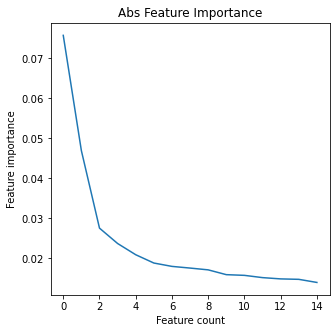

Importance 35.72996590368706 % for a subset of 15 features


In [183]:
# Refit on whole dataset
RF_opt.fit(X,y)

feature_importance = pd.DataFrame(RF_opt.feature_importances_,columns=['Importance'])
feature_importance = feature_importance.sort_values(by = ['Importance'], ascending=False)
#feature_importance = feature_importance.reset_index(drop=True)
    
#feature_importance.to_csv('feature_importance_RandomForest.csv',index=False)
print(feature_importance.head(20))

n_feats = 15
plt.figure(figsize=[5,5])
plt.plot(feature_importance['Importance'].values[0:n_feats])
plt.title('Abs Feature Importance')
plt.xlabel('Feature count')
plt.ylabel('Feature importance')
plt.show()

# Relative importance of regions
print('Importance ' + str(np.sum(feature_importance['Importance'][0:n_feats]*100)) + ' % for a subset of ' +str(n_feats) + ' features')

# Top indices
topIndices = np.array(feature_importance.head(n_feats).index)

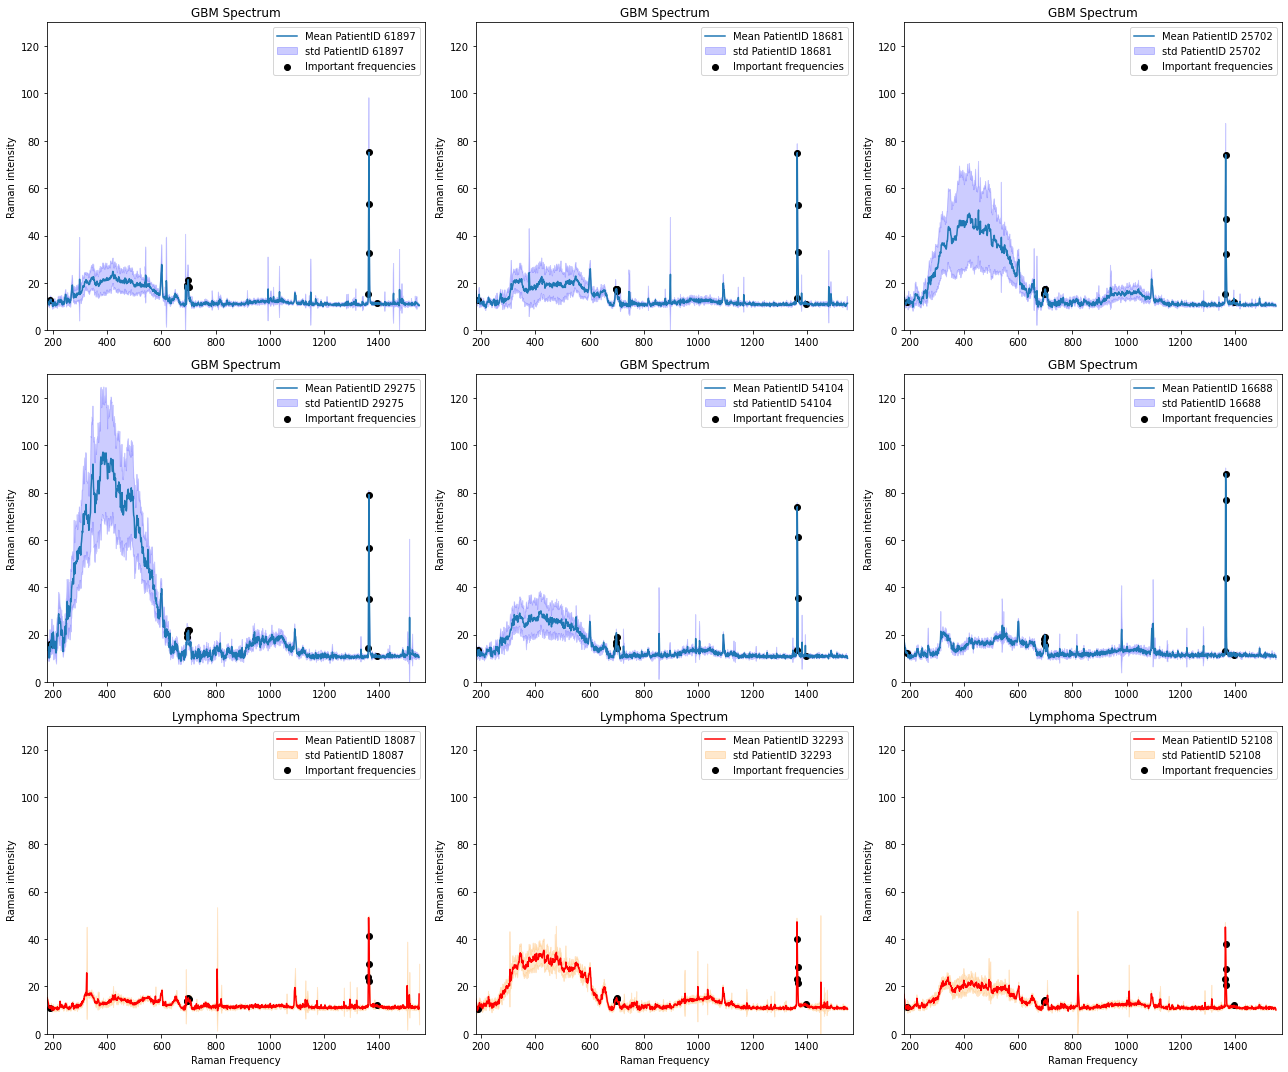

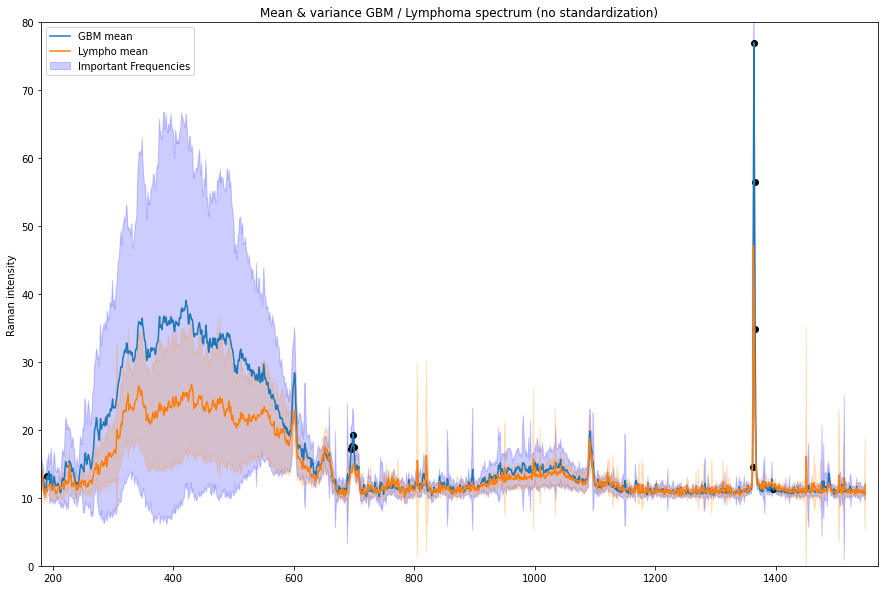

In [197]:
# Print top indices on top of patient spectrum data
uniqueGBMPatient = gbm_patientID['PatientID'].unique()
uniqueLymphoPatient = lympho_patientID['PatientID'].unique()

plt.figure(figsize=[18,15])
temp = 1
for patientID in uniqueGBMPatient:
    spectrumToConsider = gbm_data[gbm_patientID['PatientID'] == patientID].reset_index(drop=True)
    mean_spec = spectrumToConsider.mean(axis=0)
    std_spec = spectrumToConsider.std(axis=0)  
    plt.subplot(3,3,temp)
    plt.title('GBM Spectrum')
    plt.ylabel('Raman intensity')
    plt.plot(x_axis_ticks, mean_spec, label='Mean PatientID ' + str(patientID))
    plt.fill_between(x_axis_ticks, mean_spec - std_spec, mean_spec + std_spec, color='blue', alpha=.2, label='std PatientID ' + str(patientID))
    plt.scatter(np.array(x_axis_ticks)[topIndices],mean_spec[topIndices],label='Important frequencies',color='black')
    plt.legend(loc='upper right')
    plt.xlim((180,1570))
    plt.ylim((0,130))
    temp = temp + 1
    #plt.savefig('GBM_Patient_' + str(patientID) + '.pdf')
    
for patientID in uniqueLymphoPatient:
    spectrumToConsider = lympho_data[lympho_patientID['PatientID'] == patientID].reset_index(drop=True)
    mean_spec = spectrumToConsider.mean(axis=0)
    std_spec = spectrumToConsider.std(axis=0)
    plt.subplot(3,3,temp)
    plt.title('Lymphoma Spectrum')
    plt.xlabel('Raman Frequency')
    plt.ylabel('Raman intensity')
    plt.plot(x_axis_ticks, mean_spec, color='red',label='Mean PatientID ' + str(patientID))
    plt.fill_between(x_axis_ticks, mean_spec - std_spec, mean_spec + std_spec, color='darkorange', alpha=.2, label='std PatientID ' + str(patientID))
    plt.scatter(np.array(x_axis_ticks)[topIndices],mean_spec[topIndices],label='Important frequencies',color='black')
    plt.legend(loc='upper right')
    #plt.savefig('Lymphoma_Patient_' + str(patientID) + '.pdf')
    plt.xlim((180,1570))
    plt.ylim((0,130))
    temp = temp + 1
plt.tight_layout()
#plt.savefig('All patients.pdf')
plt.show()

plt.figure()
plt.title('Mean & variance GBM / Lymphoma spectrum (no standardization)')
plt.ylabel('Raman intensity')
plt.plot(x_axis_ticks, mean_GBM)
plt.plot(x_axis_ticks, mean_lympho)
plt.fill_between(x_axis_ticks, mean_GBM - std_GBM, mean_GBM + std_GBM, color='blue', alpha=.2)
plt.fill_between(x_axis_ticks, mean_lympho - std_lympho, mean_lympho + std_lympho, color='darkorange', alpha=.2)
plt.scatter(np.array(x_axis_ticks)[topIndices],mean_GBM[topIndices],color='black')
plt.legend(['GBM mean','Lympho mean','Important Frequencies'],loc='upper left')
plt.xlim((180,1570))
plt.ylim((0,80))
#plt.savefig('GBM_Lymphoma_mean_std.pdf')
plt.show()